# Quick Start
Here’s a basic example of how to use **pyramid-learn**, or **midlearn**, to explain a trained LightGBM model, utilizing the familiar scikit-learn API.

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn import set_config

import lightgbm as lgb
import midlearn as mid 

# Set up plotnine theme for clean visualizations
import plotnine as p9
p9.theme_set(p9.theme_bw(base_family='serif'))
p9.options.figure_size = (5, 4)

# Configure scikit-learn display
set_config(display='text')

## 1. Train a Black-Box Model
We use the California Housing dataset to train a LightGBM Regressor, which will serve as our black-box model.

In [20]:
# Load and prepare data
bikeshare = fetch_openml(data_id=42712)
X = pd.DataFrame(bikeshare.data, columns=bikeshare.feature_names)
y = bikeshare.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit a LightGBM regression model
estimator = lgb.LGBMRegressor(
    force_col_wise=True,
    n_estimators=500,
    random_state=42
)
estimator.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 13034, number of used features: 12
[LightGBM] [Info] Start training from score 190.379623


LGBMRegressor(force_col_wise=True, n_estimators=500, random_state=42)

In [73]:
model_pred = estimator.predict(X_test)
rmse = root_mean_squared_error(model_pred, y_test)
print(f"RMSE: {round(rmse, 6)}")

RMSE: 37.615267


## 2. Create an Explaination Model
We fit the `MIDExplainer` to the training data to create a globally faithful, interpretable surrogate model (MID).

In [13]:
# Initialize and fit the MID model
explainer = mid.MIDExplainer(
    estimator=estimator,
    penalty=.05,
    singular_ok=True,
    interactions=True,
    encoding_frames={'hour':list(range(24))}
)
explainer.fit(X_train)

Generating predictions from the estimator...


R callback write-console: singular fit encountered
  


MIDExplainer(encoding_frames={'hour': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23]},
             estimator=LGBMRegressor(n_estimators=500, random_state=42),
             penalty=0.05, singular_ok=True)

Generating predictions from the estimator...


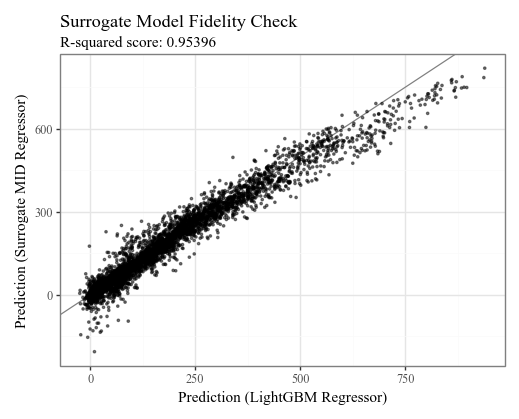

In [24]:
# Check the fidelity of the surrogate model to the original model
p = p9.ggplot() \
    + p9.geom_abline(slope=1, color='gray') \
    + p9.geom_point(p9.aes(estimator.predict(X_test), explainer.predict(X_test)), alpha=0.5, shape=".") \
    + p9.labs(
        x='Prediction (LightGBM Regressor)',
        y='Prediction (Surrogate MID Regressor)',
        title='Surrogate Model Fidelity Check',
        subtitle=f'R-squared score: {round(explainer.fidelity_score(X_test), 6)}',
    )
p

## 3. Visualize the Explanation Model
The MID model allows for clear visualization of feature importance, individual effects, and local prediction breakdowns.

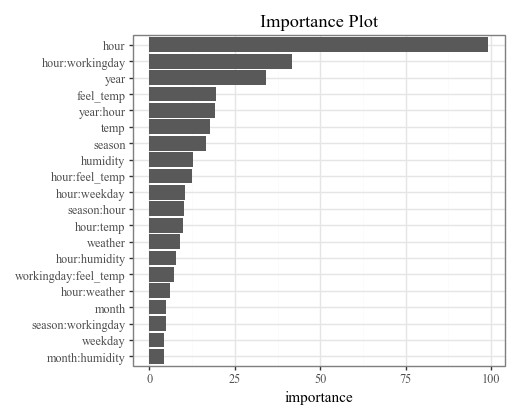

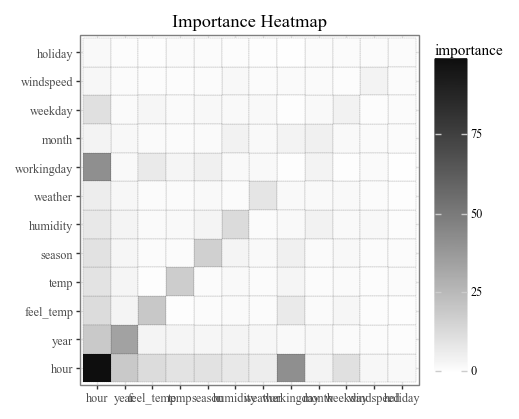

In [70]:
# Calculate and plot overall feature importance (default bar plot and heatmap)
imp = explainer.importance()
display(
    imp.plot(max_nterms=20) +
    p9.ggtitle("Importance Plot")
)
display(
    imp.plot(style='heatmap', color='black', linetype='dotted') +
    p9.ggtitle("Importance Heatmap") +
    p9.theme(legend_key_height=225)
)

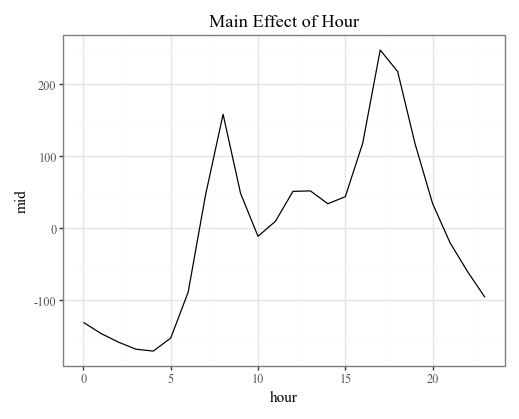

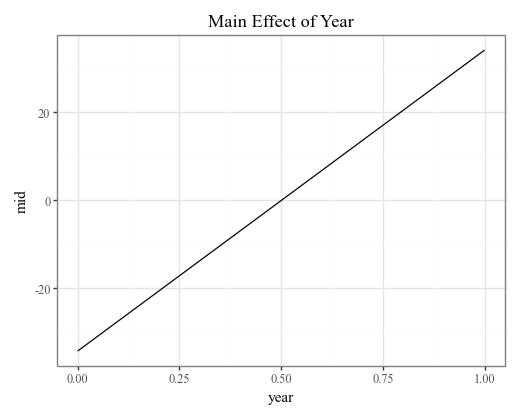

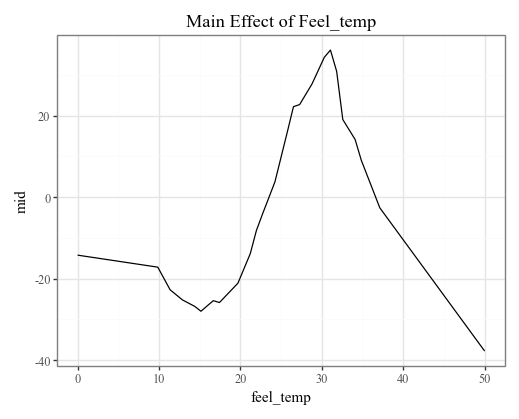

In [39]:
# Plot the top 3 important main effects (Component Functions)
for i, t in enumerate(imp.terms(interactions=False)[:3]):
    p = (
        explainer.plot(term=t) +
        p9.ggtitle(f"Main Effect of {t.capitalize()}")
    )
    display(p)

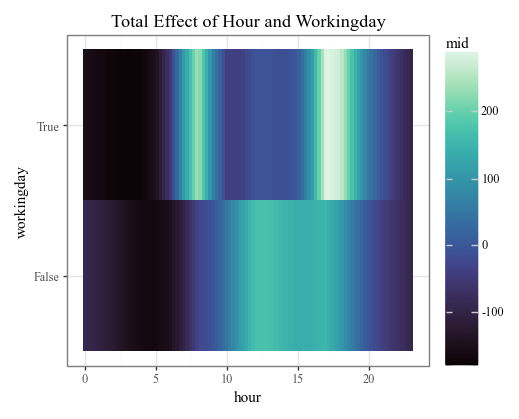

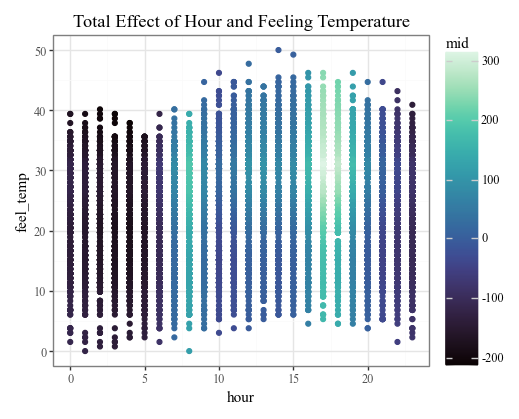

In [69]:
# Plot the interaction of pairs of variables (Component Functions)
display(
    explainer.plot(
        "hour:workingday",
        theme='mako',
        main_effects=True
    ) +
    p9.ggtitle("Total Effect of Hour and Workingday") +
    p9.theme(legend_key_height=225)
)
display(
    explainer.plot(
        "hour:feel_temp",
        style='data',
        theme='mako',
        data=X_train,
        main_effects=True
    ) +
    p9.ggtitle("Total Effect of Hour and Feeling Temperature") +
    p9.theme(legend_key_height=225)
)

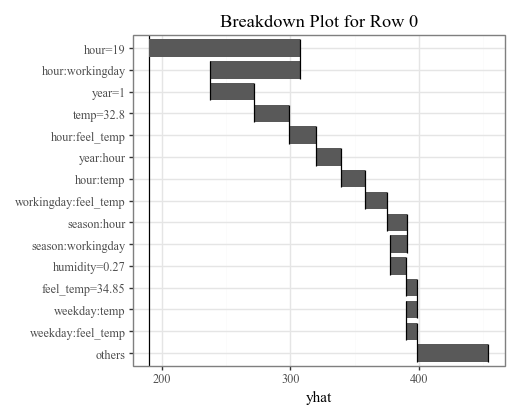

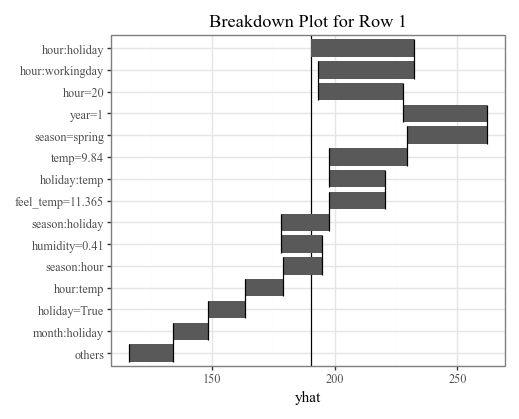

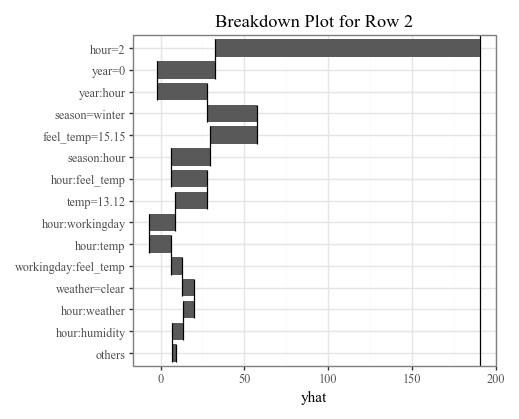

In [59]:
# Plot prediction breakdowns for the first three test samples (Local Interpretability)
for i in range(3):
    p = (
        explainer.breakdown(row=i, data=X_test).plot() +
        p9.ggtitle(f"Breakdown Plot for Row {i}")
    )
    display(p)

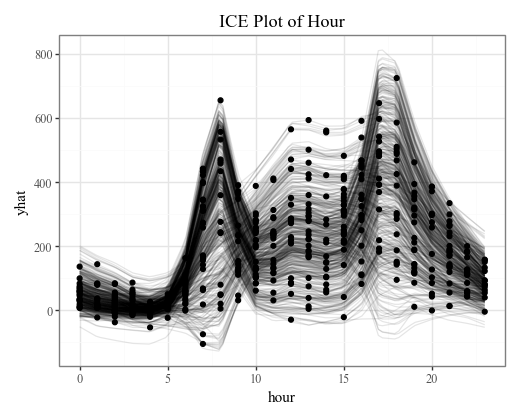

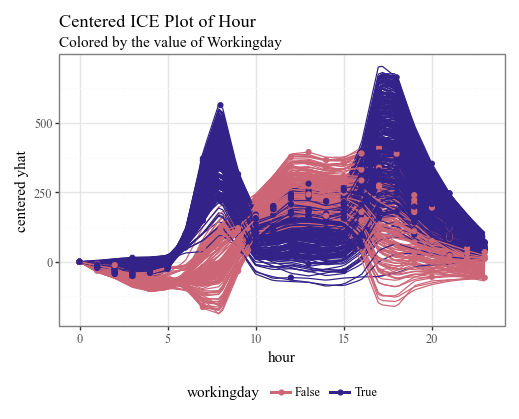

In [72]:
# Plot individual conditional expectations (ICE) with color encoding
ice = explainer.conditional(
    variable='hour',
    data=X_train.head(500)
)
display(
    ice.plot(alpha=.1) +
    p9.ggtitle("ICE Plot of Hour")
)
display(
    ice.plot(
        style='centered',
        var_color='workingday',
        theme='muted'
    ) +
    p9.labs(
        title="Centered ICE Plot of Hour",
        subtitle="Colored by the value of Workingday"
    ) +
    p9.theme(legend_position="bottom")
)